# Atari Skiing

## Part 2: Q-Learning for Atari Game Skiing

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


class DEEPQNETWORK(nn.Module):
    def __init__(self, action_size):
        super(DEEPQNETWORK, self).__init__()
        self.convolution_layer_1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.convolution_layer_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.convolution_layer_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fully_connected_1 = nn.Linear(3136, 512)
        self.fully_connected_2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.convolution_layer_1(x))
        x = torch.relu(self.convolution_layer_2(x))
        x = torch.relu(self.convolution_layer_3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fully_connected_1(x))
        return self.fully_connected_2(x)

    def save_model(self):
        torch.save(self.state_dict(), "./models/" + self.filename + ".pth")

    def load_model(self):
        self.load_state_dict(torch.load("./models/" + self.filename + ".pt"))

    # create function to load model with file name
    def load_model(self, filename):
        self.load_state_dict(torch.load("./models/" + filename + ".pt"))
        self.eval()  # Set the model to evaluation mode
        self.filename = filename  # Store the filename for future reference

In [34]:
Action = int
State = int


class DeepQLearningAgent:
    def __init__(
        self,
        learning_rate: float,
        epsilon: float,
        gamma: float,
        n_actions: int,
        batch_size: int = 32,
        memory_size: int = 100000,
    ):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DEEPQNETWORK(n_actions).to(self.device)
        self.target_net = DEEPQNETWORK(n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Use ADAM optimizer
        # Adam is an adaptive learning rate optimization algorithm
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        # Print the parameters of the agent
        print("======== DQN Agent ========")
        print("Learning rate:", self.learning_rate)
        print("Epsilon:", self.epsilon)
        print("Gamma:", self.gamma)
        print("Batch size:", self.batch_size)
        print("Max memory size:", memory_size)
        print("Number of actions:", self.n_actions, end="\n\n")
        print("Current device used:", self.device)
        print("Optimizer:", "Adam()")
        print("Loss:", self.loss_fn)
        print("====================================", end="\n\n")

    def get_action(self, state: State) -> Action:
        # Exploration
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        # Exploitation
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)

                # Retrieve the action that maximize the approximation of Q*(s, a, theta)
                return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        reward = max(min(reward, 1.0), -1.0)
        self.memory.append((state, action, reward, next_state, done))

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).to(self.device)

        next_q_values = self.target_net(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

        loss = self.loss_fn(current_q_values, target_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self, save_max=False, max_reward=0, epoch=0):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        torch.save(self.policy_net.state_dict(), f"models/model_{epoch}_state_dict.pt")
        if save_max:
            torch.save(
                self.policy_net.state_dict(),
                f"models/max_model_load_state_dict_{max_reward}.pt",
            )

Available actions: ['NOOP', 'RIGHT', 'LEFT']

======== DQN Agent ========
Learning rate: 0.001
Epsilon: 0.9
Gamma: 0.8
Batch size: 32
Max memory size: 100000
Number of actions: 3

Current device used: cuda
Optimizer: Adam()
Loss: MSELoss()



Starting:   0%|          | 0/49 [00:00<?, ?it/s]c:\Users\baile\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\baile\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\baile\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\baile\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\baile\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



===== Epoch 1 stats =====
Min reward: -50.0
Max reward: -50.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 2 stats =====
Min reward: -100.0
Max reward: -100.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 3 stats =====
Min reward: -150.0
Max reward: -150.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 4 stats =====
Min reward: -200.0
Max reward: -200.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 5 stats =====
Min reward: -250.0
Max reward: -250.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 6 stats =====
Min reward: -300.0
Max reward: -300.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 7 stats =====
Min reward: -350.0
Max reward: -350.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.9

===== Epoch 8 stats =====
Min reward: -400.0
Max reward: -400.0
Mean reward: nan
Std reward: nan

Current agent epsilon

Episode: 1 (mean: -1399.0, std: 0.0, min: -1399.0, max: -1399.0) |:   2%|▏         | 1/49 [00:12<10:14, 12.81s/it]


===== Epoch 28 stats =====
Min reward: -1399.0
Max reward: -1.0
Mean reward: -1399.0
Std reward: 0.0

Current agent epsilon: 0.88

===== Epoch 29 stats =====
Min reward: -51.0
Max reward: -51.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 30 stats =====
Min reward: -101.0
Max reward: -101.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 31 stats =====
Min reward: -151.0
Max reward: -151.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 32 stats =====
Min reward: -201.0
Max reward: -201.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 33 stats =====
Min reward: -251.0
Max reward: -251.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 34 stats =====
Min reward: -301.0
Max reward: -301.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 35 stats =====
Min reward: -351.0
Max reward: -351.0
Mean reward: nan
Std reward: nan

Cur

Episode: 2 (mean: -1467.0, std: 0.0, min: -1467.0, max: -1467.0) |:   4%|▍         | 2/49 [00:26<10:16, 13.13s/it]


===== Epoch 57 stats =====
Min reward: -1451.0
Max reward: -1451.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.88

===== Epoch 58 stats =====
Min reward: -1467.0
Max reward: -34.0
Mean reward: -1467.0
Std reward: 0.0

Current agent epsilon: 0.86

===== Epoch 59 stats =====
Min reward: -84.0
Max reward: -84.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 60 stats =====
Min reward: -134.0
Max reward: -134.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 61 stats =====
Min reward: -184.0
Max reward: -184.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 62 stats =====
Min reward: -234.0
Max reward: -234.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 63 stats =====
Min reward: -284.0
Max reward: -284.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 64 stats =====
Min reward: -334.0
Max reward: -334.0
Mean reward: nan
Std reward: nan



Episode: 3 (mean: -1037.0, std: 0.0, min: -1037.0, max: -1037.0) |:   6%|▌         | 3/49 [00:35<08:45, 11.43s/it]


===== Epoch 78 stats =====
Min reward: -1034.0
Max reward: -1034.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.86

===== Epoch 79 stats =====
Min reward: -1037.0
Max reward: -47.0
Mean reward: -1037.0
Std reward: 0.0

Current agent epsilon: 0.85

===== Epoch 80 stats =====
Min reward: -97.0
Max reward: -97.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 81 stats =====
Min reward: -147.0
Max reward: -147.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 82 stats =====
Min reward: -197.0
Max reward: -197.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 83 stats =====
Min reward: -247.0
Max reward: -247.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 84 stats =====
Min reward: -297.0
Max reward: -297.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 85 stats =====
Min reward: -347.0
Max reward: -347.0
Mean reward: nan
Std reward: nan



Episode: 4 (mean: -1315.0, std: 0.0, min: -1315.0, max: -1315.0) |:   8%|▊         | 4/49 [00:47<08:48, 11.74s/it]


===== Epoch 104 stats =====
Min reward: -1297.0
Max reward: -1297.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.85

===== Epoch 105 stats =====
Min reward: -1315.0
Max reward: -32.0
Mean reward: -1315.0
Std reward: 0.0

Current agent epsilon: 0.83

===== Epoch 106 stats =====
Min reward: -82.0
Max reward: -82.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.83

===== Epoch 107 stats =====
Min reward: -132.0
Max reward: -132.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.83

===== Epoch 108 stats =====
Min reward: -182.0
Max reward: -182.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.83

===== Epoch 109 stats =====
Min reward: -232.0
Max reward: -232.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.83

===== Epoch 110 stats =====
Min reward: -282.0
Max reward: -282.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.83

===== Epoch 111 stats =====
Min reward: -332.0
Max reward: -332.0
Mean reward: nan
Std rewar

Episode: 5 (mean: -1127.0, std: 0.0, min: -1127.0, max: -1127.0) |:  10%|█         | 5/49 [00:57<08:03, 10.98s/it]


===== Epoch 127 stats =====
Min reward: -1127.0
Max reward: -5.0
Mean reward: -1127.0
Std reward: 0.0

Current agent epsilon: 0.81

===== Epoch 128 stats =====
Min reward: -55.0
Max reward: -55.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 129 stats =====
Min reward: -105.0
Max reward: -105.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 130 stats =====
Min reward: -155.0
Max reward: -155.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 131 stats =====
Min reward: -205.0
Max reward: -205.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 132 stats =====
Min reward: -255.0
Max reward: -255.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 133 stats =====
Min reward: -305.0
Max reward: -305.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.81

===== Epoch 134 stats =====
Min reward: -355.0
Max reward: -355.0
Mean reward: nan
Std reward: 

Episode: 6 (mean: -1100.0, std: 0.0, min: -1100.0, max: -1100.0) |:  12%|█▏        | 6/49 [01:06<07:29, 10.45s/it]


===== Epoch 149 stats =====
Min reward: -1100.0
Max reward: -5.0
Mean reward: -1100.0
Std reward: 0.0

Current agent epsilon: 0.8

===== Epoch 150 stats =====
Min reward: -55.0
Max reward: -55.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 151 stats =====
Min reward: -105.0
Max reward: -105.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 152 stats =====
Min reward: -155.0
Max reward: -155.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 153 stats =====
Min reward: -205.0
Max reward: -205.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 154 stats =====
Min reward: -255.0
Max reward: -255.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 155 stats =====
Min reward: -305.0
Max reward: -305.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.8

===== Epoch 156 stats =====
Min reward: -355.0
Max reward: -355.0
Mean reward: nan
Std reward: nan

Cu

Episode: 7 (mean: -1742.0, std: 0.0, min: -1742.0, max: -1742.0) |:  14%|█▍        | 7/49 [01:21<08:20, 11.91s/it]


===== Epoch 184 stats =====
Min reward: -1742.0
Max reward: -13.0
Mean reward: -1742.0
Std reward: 0.0

Current agent epsilon: 0.78

===== Epoch 185 stats =====
Min reward: -63.0
Max reward: -63.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 186 stats =====
Min reward: -113.0
Max reward: -113.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 187 stats =====
Min reward: -163.0
Max reward: -163.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 188 stats =====
Min reward: -213.0
Max reward: -213.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 189 stats =====
Min reward: -263.0
Max reward: -263.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 190 stats =====
Min reward: -313.0
Max reward: -313.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 191 stats =====
Min reward: -363.0
Max reward: -363.0
Mean reward: nan
Std reward:

Episode: 8 (mean: -1870.0, std: 0.0, min: -1870.0, max: -1870.0) |:  16%|█▋        | 8/49 [01:37<09:01, 13.20s/it]


===== Epoch 221 stats =====
Min reward: -1863.0
Max reward: -1863.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.78

===== Epoch 222 stats =====
Min reward: -1870.0
Max reward: -43.0
Mean reward: -1870.0
Std reward: 0.0

Current agent epsilon: 0.77

===== Epoch 223 stats =====
Min reward: -93.0
Max reward: -93.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.77

===== Epoch 224 stats =====
Min reward: -143.0
Max reward: -143.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.77

===== Epoch 225 stats =====
Min reward: -193.0
Max reward: -193.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.77

===== Epoch 226 stats =====
Min reward: -243.0
Max reward: -243.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.77

===== Epoch 227 stats =====
Min reward: -293.0
Max reward: -293.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.77

===== Epoch 228 stats =====
Min reward: -343.0
Max reward: -343.0
Mean reward: nan
Std rewar

Episode: 9 (mean: -1329.0, std: 0.0, min: -1329.0, max: -1329.0) |:  18%|█▊        | 9/49 [01:49<08:31, 12.80s/it]


===== Epoch 248 stats =====
Min reward: -1329.0
Max reward: -14.0
Mean reward: -1329.0
Std reward: 0.0

Current agent epsilon: 0.75

===== Epoch 249 stats =====
Min reward: -64.0
Max reward: -64.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 250 stats =====
Min reward: -114.0
Max reward: -114.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 251 stats =====
Min reward: -164.0
Max reward: -164.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 252 stats =====
Min reward: -214.0
Max reward: -214.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 253 stats =====
Min reward: -264.0
Max reward: -264.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 254 stats =====
Min reward: -314.0
Max reward: -314.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 255 stats =====
Min reward: -364.0
Max reward: -364.0
Mean reward: nan
Std reward:

Episode: 10 (mean: -1083.0, std: 0.0, min: -1083.0, max: -1083.0) |:  20%|██        | 10/49 [01:59<07:42, 11.86s/it]


===== Epoch 269 stats =====
Min reward: -1064.0
Max reward: -1064.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.75

===== Epoch 270 stats =====
Min reward: -1083.0
Max reward: -31.0
Mean reward: -1083.0
Std reward: 0.0

Current agent epsilon: 0.74

===== Epoch 271 stats =====
Min reward: -81.0
Max reward: -81.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.74

===== Epoch 272 stats =====
Min reward: -131.0
Max reward: -131.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.74

===== Epoch 273 stats =====
Min reward: -181.0
Max reward: -181.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.74

===== Epoch 274 stats =====
Min reward: -231.0
Max reward: -231.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.74

===== Epoch 275 stats =====
Min reward: -281.0
Max reward: -281.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.74

===== Epoch 276 stats =====
Min reward: -331.0
Max reward: -331.0
Mean reward: nan
Std rewar

Episode: 11 (mean: -1171.0, std: 0.0, min: -1171.0, max: -1171.0) |:  22%|██▏       | 11/49 [02:09<07:15, 11.47s/it]


===== Epoch 293 stats =====
Min reward: -1171.0
Max reward: -10.0
Mean reward: -1171.0
Std reward: 0.0

Current agent epsilon: 0.72

===== Epoch 294 stats =====
Min reward: -60.0
Max reward: -60.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 295 stats =====
Min reward: -110.0
Max reward: -110.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 296 stats =====
Min reward: -160.0
Max reward: -160.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 297 stats =====
Min reward: -210.0
Max reward: -210.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 298 stats =====
Min reward: -260.0
Max reward: -260.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 299 stats =====
Min reward: -310.0
Max reward: -310.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.72

===== Epoch 300 stats =====
Min reward: -360.0
Max reward: -360.0
Mean reward: nan
Std reward:

Episode: 12 (mean: -1236.0, std: 0.0, min: -1236.0, max: -1236.0) |:  24%|██▍       | 12/49 [02:21<07:03, 11.45s/it]


===== Epoch 318 stats =====
Min reward: -1236.0
Max reward: -24.0
Mean reward: -1236.0
Std reward: 0.0

Current agent epsilon: 0.71

===== Epoch 319 stats =====
Min reward: -74.0
Max reward: -74.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 320 stats =====
Min reward: -124.0
Max reward: -124.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 321 stats =====
Min reward: -174.0
Max reward: -174.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 322 stats =====
Min reward: -224.0
Max reward: -224.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 323 stats =====
Min reward: -274.0
Max reward: -274.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 324 stats =====
Min reward: -324.0
Max reward: -324.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 325 stats =====
Min reward: -374.0
Max reward: -374.0
Mean reward: nan
Std reward:

Episode: 13 (mean: -1436.0, std: 0.0, min: -1436.0, max: -1436.0) |:  27%|██▋       | 13/49 [02:34<07:07, 11.88s/it]


===== Epoch 346 stats =====
Min reward: -1424.0
Max reward: -1424.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.71

===== Epoch 347 stats =====
Min reward: -1436.0
Max reward: -38.0
Mean reward: -1436.0
Std reward: 0.0

Current agent epsilon: 0.69

===== Epoch 348 stats =====
Min reward: -88.0
Max reward: -88.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 349 stats =====
Min reward: -138.0
Max reward: -138.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 350 stats =====
Min reward: -188.0
Max reward: -188.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 351 stats =====
Min reward: -238.0
Max reward: -238.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 352 stats =====
Min reward: -288.0
Max reward: -288.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 353 stats =====
Min reward: -338.0
Max reward: -338.0
Mean reward: nan
Std rewar

Episode: 14 (mean: -1046.0, std: 0.0, min: -1046.0, max: -1046.0) |:  29%|██▊       | 14/49 [02:43<06:26, 11.04s/it]


===== Epoch 367 stats =====
Min reward: -1038.0
Max reward: -1038.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.69

===== Epoch 368 stats =====
Min reward: -1046.0
Max reward: -42.0
Mean reward: -1046.0
Std reward: 0.0

Current agent epsilon: 0.68

===== Epoch 369 stats =====
Min reward: -92.0
Max reward: -92.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.68

===== Epoch 370 stats =====
Min reward: -142.0
Max reward: -142.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.68

===== Epoch 371 stats =====
Min reward: -192.0
Max reward: -192.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.68

===== Epoch 372 stats =====
Min reward: -242.0
Max reward: -242.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.68

===== Epoch 373 stats =====
Min reward: -292.0
Max reward: -292.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.68

===== Epoch 374 stats =====
Min reward: -342.0
Max reward: -342.0
Mean reward: nan
Std rewar

Episode: 15 (mean: -1387.0, std: 0.0, min: -1387.0, max: -1387.0) |:  31%|███       | 15/49 [02:55<06:29, 11.47s/it]


===== Epoch 395 stats =====
Min reward: -1387.0
Max reward: -5.0
Mean reward: -1387.0
Std reward: 0.0

Current agent epsilon: 0.66

===== Epoch 396 stats =====
Min reward: -55.0
Max reward: -55.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 397 stats =====
Min reward: -105.0
Max reward: -105.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 398 stats =====
Min reward: -155.0
Max reward: -155.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 399 stats =====
Min reward: -205.0
Max reward: -205.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 400 stats =====
Min reward: -255.0
Max reward: -255.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 401 stats =====
Min reward: -305.0
Max reward: -305.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 402 stats =====
Min reward: -355.0
Max reward: -355.0
Mean reward: nan
Std reward: 

Episode: 16 (mean: -1458.0, std: 0.0, min: -1458.0, max: -1458.0) |:  33%|███▎      | 16/49 [03:08<06:34, 11.96s/it]


===== Epoch 424 stats =====
Min reward: -1455.0
Max reward: -1455.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.66

===== Epoch 425 stats =====
Min reward: -1458.0
Max reward: -47.0
Mean reward: -1458.0
Std reward: 0.0

Current agent epsilon: 0.65

===== Epoch 426 stats =====
Min reward: -97.0
Max reward: -97.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 427 stats =====
Min reward: -147.0
Max reward: -147.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 428 stats =====
Min reward: -197.0
Max reward: -197.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 429 stats =====
Min reward: -247.0
Max reward: -247.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 430 stats =====
Min reward: -297.0
Max reward: -297.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 431 stats =====
Min reward: -347.0
Max reward: -347.0
Mean reward: nan
Std rewar

Episode: 17 (mean: -1752.0, std: 0.0, min: -1752.0, max: -1752.0) |:  35%|███▍      | 17/49 [03:25<07:03, 13.24s/it]


===== Epoch 459 stats =====
Min reward: -1747.0
Max reward: -1747.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.65

===== Epoch 460 stats =====
Min reward: -1752.0
Max reward: -45.0
Mean reward: -1752.0
Std reward: 0.0

Current agent epsilon: 0.64

===== Epoch 461 stats =====
Min reward: -95.0
Max reward: -95.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 462 stats =====
Min reward: -145.0
Max reward: -145.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 463 stats =====
Min reward: -195.0
Max reward: -195.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 464 stats =====
Min reward: -245.0
Max reward: -245.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 465 stats =====
Min reward: -295.0
Max reward: -295.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 466 stats =====
Min reward: -345.0
Max reward: -345.0
Mean reward: nan
Std rewar

Episode: 18 (mean: -1202.0, std: 0.0, min: -1202.0, max: -1202.0) |:  37%|███▋      | 18/49 [03:36<06:30, 12.60s/it]


===== Epoch 483 stats =====
Min reward: -1195.0
Max reward: -1195.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.64

===== Epoch 484 stats =====
Min reward: -1202.0
Max reward: -43.0
Mean reward: -1202.0
Std reward: 0.0

Current agent epsilon: 0.63

===== Epoch 485 stats =====
Min reward: -93.0
Max reward: -93.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 486 stats =====
Min reward: -143.0
Max reward: -143.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 487 stats =====
Min reward: -193.0
Max reward: -193.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 488 stats =====
Min reward: -243.0
Max reward: -243.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 489 stats =====
Min reward: -293.0
Max reward: -293.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 490 stats =====
Min reward: -343.0
Max reward: -343.0
Mean reward: nan
Std rewar

Episode: 19 (mean: -1248.0, std: 0.0, min: -1248.0, max: -1248.0) |:  39%|███▉      | 19/49 [03:47<06:07, 12.24s/it]


===== Epoch 508 stats =====
Min reward: -1243.0
Max reward: -1243.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.63

===== Epoch 509 stats =====
Min reward: -1248.0
Max reward: -45.0
Mean reward: -1248.0
Std reward: 0.0

Current agent epsilon: 0.61

===== Epoch 510 stats =====
Min reward: -95.0
Max reward: -95.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 511 stats =====
Min reward: -145.0
Max reward: -145.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 512 stats =====
Min reward: -195.0
Max reward: -195.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 513 stats =====
Min reward: -245.0
Max reward: -245.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 514 stats =====
Min reward: -295.0
Max reward: -295.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 515 stats =====
Min reward: -345.0
Max reward: -345.0
Mean reward: nan
Std rewar

Episode: 20 (mean: -1255.0, std: 0.0, min: -1255.0, max: -1255.0) |:  41%|████      | 20/49 [03:59<05:51, 12.14s/it]


===== Epoch 533 stats =====
Min reward: -1245.0
Max reward: -1245.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.61

===== Epoch 534 stats =====
Min reward: -1255.0
Max reward: -40.0
Mean reward: -1255.0
Std reward: 0.0

Current agent epsilon: 0.6

===== Epoch 535 stats =====
Min reward: -90.0
Max reward: -90.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.6

===== Epoch 536 stats =====
Min reward: -140.0
Max reward: -140.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.6

===== Epoch 537 stats =====
Min reward: -190.0
Max reward: -190.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.6

===== Epoch 538 stats =====
Min reward: -240.0
Max reward: -240.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.6

===== Epoch 539 stats =====
Min reward: -290.0
Max reward: -290.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.6

===== Epoch 540 stats =====
Min reward: -340.0
Max reward: -340.0
Mean reward: nan
Std reward: nan

Episode: 21 (mean: -912.0, std: 0.0, min: -912.0, max: -912.0) |:  43%|████▎     | 21/49 [04:08<05:14, 11.22s/it]   


===== Epoch 552 stats =====
Min reward: -912.0
Max reward: -28.0
Mean reward: -912.0
Std reward: 0.0

Current agent epsilon: 0.59

===== Epoch 553 stats =====
Min reward: -78.0
Max reward: -78.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 554 stats =====
Min reward: -128.0
Max reward: -128.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 555 stats =====
Min reward: -178.0
Max reward: -178.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 556 stats =====
Min reward: -228.0
Max reward: -228.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 557 stats =====
Min reward: -278.0
Max reward: -278.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 558 stats =====
Min reward: -328.0
Max reward: -328.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.59

===== Epoch 559 stats =====
Min reward: -378.0
Max reward: -378.0
Mean reward: nan
Std reward: n

Episode: 22 (mean: -1213.0, std: 0.0, min: -1213.0, max: -1213.0) |:  45%|████▍     | 22/49 [04:20<05:09, 11.47s/it]


===== Epoch 576 stats =====
Min reward: -1213.0
Max reward: -15.0
Mean reward: -1213.0
Std reward: 0.0

Current agent epsilon: 0.58

===== Epoch 577 stats =====
Min reward: -65.0
Max reward: -65.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 578 stats =====
Min reward: -115.0
Max reward: -115.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 579 stats =====
Min reward: -165.0
Max reward: -165.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 580 stats =====
Min reward: -215.0
Max reward: -215.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 581 stats =====
Min reward: -265.0
Max reward: -265.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 582 stats =====
Min reward: -315.0
Max reward: -315.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58

===== Epoch 583 stats =====
Min reward: -365.0
Max reward: -365.0
Mean reward: nan
Std reward:

Episode: 23 (mean: -1083.0, std: 0.0, min: -1083.0, max: -1083.0) |:  45%|████▍     | 22/49 [04:31<05:09, 11.47s/it]


===== Epoch 597 stats =====
Min reward: -1065.0
Max reward: -1065.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.58


Episode: 23 (mean: -1083.0, std: 0.0, min: -1083.0, max: -1083.0) |:  47%|████▋     | 23/49 [04:31<04:56, 11.40s/it]


===== Epoch 598 stats =====
Min reward: -1083.0
Max reward: -32.0
Mean reward: -1083.0
Std reward: 0.0

Current agent epsilon: 0.57

===== Epoch 599 stats =====
Min reward: -82.0
Max reward: -82.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 600 stats =====
Min reward: -132.0
Max reward: -132.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 601 stats =====
Min reward: -182.0
Max reward: -182.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 602 stats =====
Min reward: -232.0
Max reward: -232.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 603 stats =====
Min reward: -282.0
Max reward: -282.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 604 stats =====
Min reward: -332.0
Max reward: -332.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 605 stats =====
Min reward: -382.0
Max reward: -382.0
Mean reward: nan
Std reward:

Episode: 24 (mean: -1345.0, std: 0.0, min: -1345.0, max: -1345.0) |:  49%|████▉     | 24/49 [04:45<05:00, 12.01s/it]


===== Epoch 624 stats =====
Min reward: -1332.0
Max reward: -1332.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.57

===== Epoch 625 stats =====
Min reward: -1345.0
Max reward: -37.0
Mean reward: -1345.0
Std reward: 0.0

Current agent epsilon: 0.55

===== Epoch 626 stats =====
Min reward: -87.0
Max reward: -87.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.55

===== Epoch 627 stats =====
Min reward: -137.0
Max reward: -137.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.55

===== Epoch 628 stats =====
Min reward: -187.0
Max reward: -187.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.55

===== Epoch 629 stats =====
Min reward: -237.0
Max reward: -237.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.55

===== Epoch 630 stats =====
Min reward: -287.0
Max reward: -287.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.55

===== Epoch 631 stats =====
Min reward: -337.0
Max reward: -337.0
Mean reward: nan
Std rewar

Episode: 25 (mean: -1464.0, std: 0.0, min: -1464.0, max: -1464.0) |:  51%|█████     | 25/49 [04:59<05:05, 12.72s/it]


===== Epoch 654 stats =====
Min reward: -1464.0
Max reward: -23.0
Mean reward: -1464.0
Std reward: 0.0

Current agent epsilon: 0.54

===== Epoch 655 stats =====
Min reward: -73.0
Max reward: -73.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 656 stats =====
Min reward: -123.0
Max reward: -123.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 657 stats =====
Min reward: -173.0
Max reward: -173.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 658 stats =====
Min reward: -223.0
Max reward: -223.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 659 stats =====
Min reward: -273.0
Max reward: -273.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 660 stats =====
Min reward: -323.0
Max reward: -323.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.54

===== Epoch 661 stats =====
Min reward: -373.0
Max reward: -373.0
Mean reward: nan
Std reward:

Episode: 26 (mean: -1165.0, std: 0.0, min: -1165.0, max: -1165.0) |:  53%|█████▎    | 26/49 [05:11<04:44, 12.39s/it]


===== Epoch 677 stats =====
Min reward: -1165.0
Max reward: -8.0
Mean reward: -1165.0
Std reward: 0.0

Current agent epsilon: 0.53

===== Epoch 678 stats =====
Min reward: -58.0
Max reward: -58.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 679 stats =====
Min reward: -108.0
Max reward: -108.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 680 stats =====
Min reward: -158.0
Max reward: -158.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 681 stats =====
Min reward: -208.0
Max reward: -208.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 682 stats =====
Min reward: -258.0
Max reward: -258.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 683 stats =====
Min reward: -308.0
Max reward: -308.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 684 stats =====
Min reward: -358.0
Max reward: -358.0
Mean reward: nan
Std reward: 

Episode: 27 (mean: -1124.0, std: 0.0, min: -1124.0, max: -1124.0) |:  55%|█████▌    | 27/49 [05:22<04:24, 12.03s/it]


===== Epoch 699 stats =====
Min reward: -1108.0
Max reward: -1108.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.53

===== Epoch 700 stats =====
Min reward: -1124.0
Max reward: -34.0
Mean reward: -1124.0
Std reward: 0.0

Current agent epsilon: 0.52

===== Epoch 701 stats =====
Min reward: -84.0
Max reward: -84.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 702 stats =====
Min reward: -134.0
Max reward: -134.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 703 stats =====
Min reward: -184.0
Max reward: -184.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 704 stats =====
Min reward: -234.0
Max reward: -234.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 705 stats =====
Min reward: -284.0
Max reward: -284.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 706 stats =====
Min reward: -334.0
Max reward: -334.0
Mean reward: nan
Std rewar

Episode: 28 (mean: -999.0, std: 0.0, min: -999.0, max: -999.0) |:  57%|█████▋    | 28/49 [05:32<03:58, 11.38s/it]   


===== Epoch 719 stats =====
Min reward: -984.0
Max reward: -984.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.52

===== Epoch 720 stats =====
Min reward: -999.0
Max reward: -35.0
Mean reward: -999.0
Std reward: 0.0

Current agent epsilon: 0.51

===== Epoch 721 stats =====
Min reward: -85.0
Max reward: -85.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51

===== Epoch 722 stats =====
Min reward: -135.0
Max reward: -135.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51

===== Epoch 723 stats =====
Min reward: -185.0
Max reward: -185.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51

===== Epoch 724 stats =====
Min reward: -235.0
Max reward: -235.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51

===== Epoch 725 stats =====
Min reward: -285.0
Max reward: -285.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51

===== Epoch 726 stats =====
Min reward: -335.0
Max reward: -335.0
Mean reward: nan
Std reward: n

Episode: 29 (mean: -1049.0, std: 0.0, min: -1049.0, max: -1049.0) |:  57%|█████▋    | 28/49 [05:43<03:58, 11.38s/it]


===== Epoch 740 stats =====
Min reward: -1035.0
Max reward: -1035.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.51


Episode: 29 (mean: -1049.0, std: 0.0, min: -1049.0, max: -1049.0) |:  59%|█████▉    | 29/49 [05:43<03:45, 11.26s/it]


===== Epoch 741 stats =====
Min reward: -1049.0
Max reward: -36.0
Mean reward: -1049.0
Std reward: 0.0

Current agent epsilon: 0.5

===== Epoch 742 stats =====
Min reward: -86.0
Max reward: -86.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 743 stats =====
Min reward: -136.0
Max reward: -136.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 744 stats =====
Min reward: -186.0
Max reward: -186.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 745 stats =====
Min reward: -236.0
Max reward: -236.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 746 stats =====
Min reward: -286.0
Max reward: -286.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 747 stats =====
Min reward: -336.0
Max reward: -336.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.5

===== Epoch 748 stats =====
Min reward: -386.0
Max reward: -386.0
Mean reward: nan
Std reward: nan

C

Episode: 30 (mean: -1360.0, std: 0.0, min: -1360.0, max: -1360.0) |:  61%|██████    | 30/49 [05:57<03:49, 12.08s/it]


===== Epoch 768 stats =====
Min reward: -1360.0
Max reward: -26.0
Mean reward: -1360.0
Std reward: 0.0

Current agent epsilon: 0.49

===== Epoch 769 stats =====
Min reward: -76.0
Max reward: -76.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 770 stats =====
Min reward: -126.0
Max reward: -126.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 771 stats =====
Min reward: -176.0
Max reward: -176.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 772 stats =====
Min reward: -226.0
Max reward: -226.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 773 stats =====
Min reward: -276.0
Max reward: -276.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 774 stats =====
Min reward: -326.0
Max reward: -326.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.49

===== Epoch 775 stats =====
Min reward: -376.0
Max reward: -376.0
Mean reward: nan
Std reward:

Episode: 31 (mean: -1126.0, std: 0.0, min: -1126.0, max: -1126.0) |:  63%|██████▎   | 31/49 [06:08<03:33, 11.87s/it]


===== Epoch 790 stats =====
Min reward: -1126.0
Max reward: -1126.0
Mean reward: -1126.0
Std reward: 0.0

Current agent epsilon: 0.49

===== Epoch 791 stats =====
Min reward: -50.0
Max reward: -50.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 792 stats =====
Min reward: -100.0
Max reward: -100.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 793 stats =====
Min reward: -150.0
Max reward: -150.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 794 stats =====
Min reward: -200.0
Max reward: -200.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 795 stats =====
Min reward: -250.0
Max reward: -250.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 796 stats =====
Min reward: -300.0
Max reward: -300.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 797 stats =====
Min reward: -350.0
Max reward: -350.0
Mean reward: nan
Std rewar

Episode: 32 (mean: -1555.0, std: 0.0, min: -1555.0, max: -1555.0) |:  65%|██████▌   | 32/49 [06:24<03:40, 12.94s/it]


===== Epoch 821 stats =====
Min reward: -1550.0
Max reward: -1550.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.48

===== Epoch 822 stats =====
Min reward: -1555.0
Max reward: -45.0
Mean reward: -1555.0
Std reward: 0.0

Current agent epsilon: 0.47

===== Epoch 823 stats =====
Min reward: -95.0
Max reward: -95.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.47

===== Epoch 824 stats =====
Min reward: -145.0
Max reward: -145.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.47

===== Epoch 825 stats =====
Min reward: -195.0
Max reward: -195.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.47

===== Epoch 826 stats =====
Min reward: -245.0
Max reward: -245.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.47

===== Epoch 827 stats =====
Min reward: -295.0
Max reward: -295.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.47

===== Epoch 828 stats =====
Min reward: -345.0
Max reward: -345.0
Mean reward: nan
Std rewar

Episode: 33 (mean: -1380.0, std: 0.0, min: -1380.0, max: -1380.0) |:  67%|██████▋   | 33/49 [06:38<03:31, 13.22s/it]


===== Epoch 849 stats =====
Min reward: -1380.0
Max reward: -15.0
Mean reward: -1380.0
Std reward: 0.0

Current agent epsilon: 0.46

===== Epoch 850 stats =====
Min reward: -65.0
Max reward: -65.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 851 stats =====
Min reward: -115.0
Max reward: -115.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 852 stats =====
Min reward: -165.0
Max reward: -165.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 853 stats =====
Min reward: -215.0
Max reward: -215.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 854 stats =====
Min reward: -265.0
Max reward: -265.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 855 stats =====
Min reward: -315.0
Max reward: -315.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.46

===== Epoch 856 stats =====
Min reward: -365.0
Max reward: -365.0
Mean reward: nan
Std reward:

Episode: 34 (mean: -1404.0, std: 0.0, min: -1404.0, max: -1404.0) |:  69%|██████▉   | 34/49 [06:51<03:20, 13.36s/it]


===== Epoch 877 stats =====
Min reward: -1404.0
Max reward: -11.0
Mean reward: -1404.0
Std reward: 0.0

Current agent epsilon: 0.45

===== Epoch 878 stats =====
Min reward: -61.0
Max reward: -61.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 879 stats =====
Min reward: -111.0
Max reward: -111.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 880 stats =====
Min reward: -161.0
Max reward: -161.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 881 stats =====
Min reward: -211.0
Max reward: -211.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 882 stats =====
Min reward: -261.0
Max reward: -261.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 883 stats =====
Min reward: -311.0
Max reward: -311.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.45

===== Epoch 884 stats =====
Min reward: -361.0
Max reward: -361.0
Mean reward: nan
Std reward:

Episode: 35 (mean: -1440.0, std: 0.0, min: -1440.0, max: -1440.0) |:  71%|███████▏  | 35/49 [07:06<03:12, 13.76s/it]


===== Epoch 906 stats =====
Min reward: -1440.0
Max reward: -21.0
Mean reward: -1440.0
Std reward: 0.0

Current agent epsilon: 0.44

===== Epoch 907 stats =====
Min reward: -71.0
Max reward: -71.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 908 stats =====
Min reward: -121.0
Max reward: -121.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 909 stats =====
Min reward: -171.0
Max reward: -171.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 910 stats =====
Min reward: -221.0
Max reward: -221.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 911 stats =====
Min reward: -271.0
Max reward: -271.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 912 stats =====
Min reward: -321.0
Max reward: -321.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 913 stats =====
Min reward: -371.0
Max reward: -371.0
Mean reward: nan
Std reward:

Episode: 36 (mean: -1432.0, std: 0.0, min: -1432.0, max: -1432.0) |:  73%|███████▎  | 36/49 [07:20<03:00, 13.90s/it]


===== Epoch 934 stats =====
Min reward: -1421.0
Max reward: -1421.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.44

===== Epoch 935 stats =====
Min reward: -1432.0
Max reward: -39.0
Mean reward: -1432.0
Std reward: 0.0

Current agent epsilon: 0.43

===== Epoch 936 stats =====
Min reward: -89.0
Max reward: -89.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 937 stats =====
Min reward: -139.0
Max reward: -139.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 938 stats =====
Min reward: -189.0
Max reward: -189.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 939 stats =====
Min reward: -239.0
Max reward: -239.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 940 stats =====
Min reward: -289.0
Max reward: -289.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 941 stats =====
Min reward: -339.0
Max reward: -339.0
Mean reward: nan
Std rewar

Episode: 37 (mean: -1237.0, std: 0.0, min: -1237.0, max: -1237.0) |:  76%|███████▌  | 37/49 [07:32<02:39, 13.25s/it]


===== Epoch 959 stats =====
Min reward: -1237.0
Max reward: -2.0
Mean reward: -1237.0
Std reward: 0.0

Current agent epsilon: 0.43

===== Epoch 960 stats =====
Min reward: -52.0
Max reward: -52.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 961 stats =====
Min reward: -102.0
Max reward: -102.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 962 stats =====
Min reward: -152.0
Max reward: -152.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 963 stats =====
Min reward: -202.0
Max reward: -202.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 964 stats =====
Min reward: -252.0
Max reward: -252.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 965 stats =====
Min reward: -302.0
Max reward: -302.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 966 stats =====
Min reward: -352.0
Max reward: -352.0
Mean reward: nan
Std reward: 

Episode: 38 (mean: -1355.0, std: 0.0, min: -1355.0, max: -1355.0) |:  78%|███████▊  | 38/49 [07:49<02:37, 14.32s/it]


===== Epoch 986 stats =====
Min reward: -1352.0
Max reward: -1352.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.43

===== Epoch 987 stats =====
Min reward: -1355.0
Max reward: -47.0
Mean reward: -1355.0
Std reward: 0.0

Current agent epsilon: 0.42

===== Epoch 988 stats =====
Min reward: -97.0
Max reward: -97.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 989 stats =====
Min reward: -147.0
Max reward: -147.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 990 stats =====
Min reward: -197.0
Max reward: -197.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 991 stats =====
Min reward: -247.0
Max reward: -247.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 992 stats =====
Min reward: -297.0
Max reward: -297.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 993 stats =====
Min reward: -347.0
Max reward: -347.0
Mean reward: nan
Std rewar

Episode: 39 (mean: -1260.0, std: 0.0, min: -1260.0, max: -1260.0) |:  80%|███████▉  | 39/49 [08:01<02:17, 13.77s/it]


===== Epoch 1011 stats =====
Min reward: -1247.0
Max reward: -1247.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.42

===== Epoch 1012 stats =====
Min reward: -1260.0
Max reward: -37.0
Mean reward: -1260.0
Std reward: 0.0

Current agent epsilon: 0.41

===== Epoch 1013 stats =====
Min reward: -87.0
Max reward: -87.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.41

===== Epoch 1014 stats =====
Min reward: -137.0
Max reward: -137.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.41

===== Epoch 1015 stats =====
Min reward: -187.0
Max reward: -187.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.41

===== Epoch 1016 stats =====
Min reward: -237.0
Max reward: -237.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.41

===== Epoch 1017 stats =====
Min reward: -287.0
Max reward: -287.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.41

===== Epoch 1018 stats =====
Min reward: -337.0
Max reward: -337.0
Mean reward: nan
S

Episode: 40 (mean: -1227.0, std: 0.0, min: -1227.0, max: -1227.0) |:  82%|████████▏ | 40/49 [08:16<02:05, 13.96s/it]


===== Epoch 1036 stats =====
Min reward: -1227.0
Max reward: -10.0
Mean reward: -1227.0
Std reward: 0.0

Current agent epsilon: 0.4

===== Epoch 1037 stats =====
Min reward: -60.0
Max reward: -60.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1038 stats =====
Min reward: -110.0
Max reward: -110.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1039 stats =====
Min reward: -160.0
Max reward: -160.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1040 stats =====
Min reward: -210.0
Max reward: -210.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1041 stats =====
Min reward: -260.0
Max reward: -260.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1042 stats =====
Min reward: -310.0
Max reward: -310.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.4

===== Epoch 1043 stats =====
Min reward: -360.0
Max reward: -360.0
Mean reward: nan
Std reward

Episode: 41 (mean: -941.0, std: 0.0, min: -941.0, max: -941.0) |:  84%|████████▎ | 41/49 [08:24<01:39, 12.43s/it]   


===== Epoch 1055 stats =====
Min reward: -941.0
Max reward: -19.0
Mean reward: -941.0
Std reward: 0.0

Current agent epsilon: 0.39

===== Epoch 1056 stats =====
Min reward: -69.0
Max reward: -69.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1057 stats =====
Min reward: -119.0
Max reward: -119.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1058 stats =====
Min reward: -169.0
Max reward: -169.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1059 stats =====
Min reward: -219.0
Max reward: -219.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1060 stats =====
Min reward: -269.0
Max reward: -269.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1061 stats =====
Min reward: -319.0
Max reward: -319.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1062 stats =====
Min reward: -369.0
Max reward: -369.0
Mean reward: nan
Std r

Episode: 42 (mean: -1095.0, std: 0.0, min: -1095.0, max: -1095.0) |:  86%|████████▌ | 42/49 [08:35<01:23, 11.86s/it]


===== Epoch 1077 stats =====
Min reward: -1095.0
Max reward: -24.0
Mean reward: -1095.0
Std reward: 0.0

Current agent epsilon: 0.39

===== Epoch 1078 stats =====
Min reward: -74.0
Max reward: -74.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1079 stats =====
Min reward: -124.0
Max reward: -124.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1080 stats =====
Min reward: -174.0
Max reward: -174.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1081 stats =====
Min reward: -224.0
Max reward: -224.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1082 stats =====
Min reward: -274.0
Max reward: -274.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1083 stats =====
Min reward: -324.0
Max reward: -324.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.39

===== Epoch 1084 stats =====
Min reward: -374.0
Max reward: -374.0
Mean reward: nan
Std

Episode: 43 (mean: -1649.0, std: 0.0, min: -1649.0, max: -1649.0) |:  88%|████████▊ | 43/49 [08:54<01:24, 14.06s/it]


===== Epoch 1110 stats =====
Min reward: -1649.0
Max reward: -25.0
Mean reward: -1649.0
Std reward: 0.0

Current agent epsilon: 0.38

===== Epoch 1111 stats =====
Min reward: -75.0
Max reward: -75.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1112 stats =====
Min reward: -125.0
Max reward: -125.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1113 stats =====
Min reward: -175.0
Max reward: -175.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1114 stats =====
Min reward: -225.0
Max reward: -225.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1115 stats =====
Min reward: -275.0
Max reward: -275.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1116 stats =====
Min reward: -325.0
Max reward: -325.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1117 stats =====
Min reward: -375.0
Max reward: -375.0
Mean reward: nan
Std

Episode: 44 (mean: -1384.0, std: 0.0, min: -1384.0, max: -1384.0) |:  90%|████████▉ | 44/49 [09:07<01:08, 13.78s/it]


===== Epoch 1137 stats =====
Min reward: -1375.0
Max reward: -1375.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.38

===== Epoch 1138 stats =====
Min reward: -1384.0
Max reward: -41.0
Mean reward: -1384.0
Std reward: 0.0

Current agent epsilon: 0.37

===== Epoch 1139 stats =====
Min reward: -91.0
Max reward: -91.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1140 stats =====
Min reward: -141.0
Max reward: -141.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1141 stats =====
Min reward: -191.0
Max reward: -191.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1142 stats =====
Min reward: -241.0
Max reward: -241.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1143 stats =====
Min reward: -291.0
Max reward: -291.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1144 stats =====
Min reward: -341.0
Max reward: -341.0
Mean reward: nan
S

Episode: 45 (mean: -1704.0, std: 0.0, min: -1704.0, max: -1704.0) |:  92%|█████████▏| 45/49 [09:25<01:00, 15.02s/it]


===== Epoch 1171 stats =====
Min reward: -1691.0
Max reward: -1691.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.37

===== Epoch 1172 stats =====
Min reward: -1704.0
Max reward: -37.0
Mean reward: -1704.0
Std reward: 0.0

Current agent epsilon: 0.36

===== Epoch 1173 stats =====
Min reward: -87.0
Max reward: -87.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1174 stats =====
Min reward: -137.0
Max reward: -137.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1175 stats =====
Min reward: -187.0
Max reward: -187.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1176 stats =====
Min reward: -237.0
Max reward: -237.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1177 stats =====
Min reward: -287.0
Max reward: -287.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1178 stats =====
Min reward: -337.0
Max reward: -337.0
Mean reward: nan
S

Episode: 46 (mean: -1115.0, std: 0.0, min: -1115.0, max: -1115.0) |:  94%|█████████▍| 46/49 [09:37<00:41, 13.92s/it]


===== Epoch 1194 stats =====
Min reward: -1115.0
Max reward: -22.0
Mean reward: -1115.0
Std reward: 0.0

Current agent epsilon: 0.36

===== Epoch 1195 stats =====
Min reward: -72.0
Max reward: -72.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1196 stats =====
Min reward: -122.0
Max reward: -122.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1197 stats =====
Min reward: -172.0
Max reward: -172.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1198 stats =====
Min reward: -222.0
Max reward: -222.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1199 stats =====
Min reward: -272.0
Max reward: -272.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1200 stats =====
Min reward: -322.0
Max reward: -322.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.36

===== Epoch 1201 stats =====
Min reward: -372.0
Max reward: -372.0
Mean reward: nan
Std

Episode: 47 (mean: -1472.0, std: 0.0, min: -1472.0, max: -1472.0) |:  96%|█████████▌| 47/49 [09:51<00:28, 14.03s/it]


===== Epoch 1223 stats =====
Min reward: -1472.0
Max reward: -1472.0
Mean reward: -1472.0
Std reward: 0.0

Current agent epsilon: 0.36

===== Epoch 1224 stats =====
Min reward: -50.0
Max reward: -50.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1225 stats =====
Min reward: -100.0
Max reward: -100.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1226 stats =====
Min reward: -150.0
Max reward: -150.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1227 stats =====
Min reward: -200.0
Max reward: -200.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1228 stats =====
Min reward: -250.0
Max reward: -250.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1229 stats =====
Min reward: -300.0
Max reward: -300.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.35

===== Epoch 1230 stats =====
Min reward: -350.0
Max reward: -350.0
Mean reward: nan
S

Episode: 48 (mean: -1186.0, std: 0.0, min: -1186.0, max: -1186.0) |:  98%|█████████▊| 48/49 [10:03<00:13, 13.44s/it]


===== Epoch 1247 stats =====
Min reward: -1186.0
Max reward: -14.0
Mean reward: -1186.0
Std reward: 0.0

Current agent epsilon: 0.34

===== Epoch 1248 stats =====
Min reward: -64.0
Max reward: -64.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1249 stats =====
Min reward: -114.0
Max reward: -114.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1250 stats =====
Min reward: -164.0
Max reward: -164.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1251 stats =====
Min reward: -214.0
Max reward: -214.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1252 stats =====
Min reward: -264.0
Max reward: -264.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1253 stats =====
Min reward: -314.0
Max reward: -314.0
Mean reward: nan
Std reward: nan

Current agent epsilon: 0.34

===== Epoch 1254 stats =====
Min reward: -364.0
Max reward: -364.0
Mean reward: nan
Std

Episode: 49 (mean: -1591.0, std: 0.0, min: -1591.0, max: -1591.0) |: 100%|██████████| 49/49 [10:20<00:00, 12.66s/it]


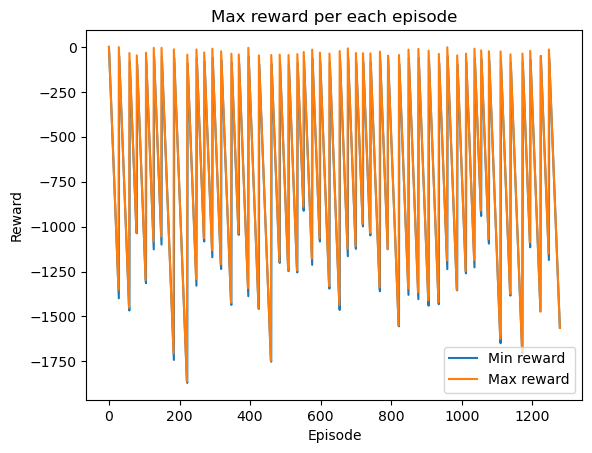

In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import AtariPreprocessing
import ale_py
from tqdm import tqdm


def preprocess_observation(obs):
    return np.array(obs).astype(np.float32) / 255.0


gym.register_envs(ale_py)
env = gym.make("ALE/Skiing-v5", obs_type="grayscale", frameskip=4)
env = AtariPreprocessing(env, frame_skip=1)
env = gym.wrappers.FrameStackObservation(env, 4)

n_actions = env.action_space.n
print("Available actions:", env.unwrapped.get_action_meanings(), end="\n\n")

agent = DeepQLearningAgent(
    learning_rate=0.001,
    epsilon=.9,
    gamma=0.8,
    n_actions=n_actions,
    batch_size=32,
    memory_size=100000,
)

n_episodes = 50
target_update_frequency = 50
epsilon_decay =  0.98
epsilon_min = 0.05
one_epoch = 50

mean_reward = []
mini_batch = 0
max_reward = float("-inf")
min_reward = float("inf")

epoch_values = [0]
std_values = [0]
max_rewards = [0]
min_rewards = [0]

best_reward = 0
progress_bar = tqdm(range(1, n_episodes), desc="Starting")
for episode in progress_bar:
    obs, _ = env.reset()
    state = preprocess_observation(obs)
    done = False
    total_reward = 0.0
    current_frame = mini_batch

    # env.render()
    while not done:
        action = 0 if current_frame == mini_batch else agent.get_action(state)


        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += np.clip(reward, -1, 1)

        next_state = preprocess_observation(obs)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        mini_batch += 1

        if done:
            mean_reward.append(total_reward)

            avg_reward = round(np.mean(mean_reward).item(), 2)
            max_reward = round(max(max_reward, total_reward), 2)
            min_reward = round(min(min_reward, total_reward), 2)
            std_reward = round(np.std(mean_reward).item(), 2)

            progress_bar.set_description(
                desc=f"Episode: {episode} (mean: {avg_reward}, std: {std_reward}, min: {min_reward}, max: {max_reward}) |"
            )

        if mini_batch % one_epoch == 0:
            current_epoch = len(epoch_values)
            avg_reward = round(np.mean(mean_reward).item(), 2)
            max_reward = round(max(max_reward, total_reward), 2)
            min_reward = round(min(min_reward, total_reward), 2)
            std_reward = round(np.std(mean_reward).item(), 2)

            print(f"\n===== Epoch {current_epoch} stats =====")
            print(f"Min reward: {min_reward}")
            print(f"Max reward: {max_reward}")
            print(f"Mean reward: {avg_reward}")
            print(f"Std reward: {std_reward}\n")
            print("Current agent epsilon:", round(agent.epsilon, 2))
            mean_reward.clear()

            epoch_values.append(avg_reward)
            std_values.append(std_reward)
            min_rewards.append(min_reward)
            max_rewards.append(max_reward)

            max_reward = float("-inf")
            min_reward = float("inf")

        # Update target network and plot stats
        if mini_batch % target_update_frequency == 0:
            current_epoch = len(epoch_values)
            save_max_network = False
            if epoch_values[-1] > best_reward:
                best_reward = epoch_values[-1]
                save_max_network = True
                print(f"New max_reward net with r={max_reward}")
            agent.update_target_network(
                save_max=save_max_network,
                max_reward=max_reward,
                epoch=current_epoch,
            )

    # Decay epsilon
    agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)

env.close()

# plot max reward per each episode
import matplotlib.pyplot as plt

plt.plot(min_rewards, label="Min reward")
plt.plot(max_rewards, label="Max reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Max reward per each episode")
plt.legend()
plt.show()